# Random Forest Tuning (Descriptors + Fingerprints)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna

## Logging results

In [2]:
import pandas as pd

# Глобальный список для хранения всех результатов
all_results = []


def log_result(method_name, model_type, n_features, metrics, params=None, stage=None):
    """
    Сохраняет результаты в глобальную таблицу all_results.

    method_name — SHAP / MI / KBest / Lasso
    model_type — RF / OptunaRF / ExtraTrees / GBoost
    n_features — количество используемых фичей
    metrics — словарь метрик {"Accuracy":..., "F1":..., ...}
    params — словарь параметров модели
    stage — этап: baseline / final / optuna / simple_tuning
    """

    record = {
        "Method": method_name,
        "Model": model_type,
        "Stage": stage,
        "Top_Features": n_features,

        # Метрики
        "Accuracy": metrics.get("Accuracy"),
        "Precision": metrics.get("Precision"),
        "Recall": metrics.get("Recall"),
        "F1": metrics.get("F1"),
        "ROC_AUC": metrics.get("AUC"),
    }

    # Добавляем параметры модели, если есть
    if params is not None:
        for key, value in params.items():
            record[f"Param_{key}"] = value

    all_results.append(record)


def save_results_table(filename="all_results.xlsx"):
    """
    Преобразует global all_results → DataFrame и сохраняет таблицу.
    """
    df = pd.DataFrame(all_results)
    df.to_excel(filename, index=False)
    print(f"Saved full results table to {filename}")
    return df


## Molecule, Descriptor + Fingerprints and Outlier Functions

In [3]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # Re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def bitvect_to_dict(fp, prefix):
    # Convert bit vector to dictionary (create features)
    n_bits = fp.GetNumBits()
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    features = {}
    for i, v in enumerate(arr):
        features[f"{prefix}_{i}"] = int(v)
    return features


def calculate_fingerprints(mol):
    RDLogger.DisableLog('rdApp.*')
    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    feats = {}
    if mol is None:
        return feats

    # Morgan (ECFP) fingerprint
    morgan_bits = 2048
    morgan_radius = 2
    fp_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=morgan_radius, nBits=morgan_bits
    )
    feats.update(bitvect_to_dict(fp_morgan, f"Morgan{morgan_radius}_{morgan_bits}"))

    # RDKit topological fingerprint
    rdk_bits = 2048
    fp_rdk = Chem.RDKFingerprint(mol, fpSize=rdk_bits)
    feats.update(bitvect_to_dict(fp_rdk, f"RDK_{rdk_bits}"))

    # MACCS keys (167 bits)
    fp_maccs = MACCSkeys.GenMACCSKeys(mol)
    feats.update(bitvect_to_dict(fp_maccs, "MACCS"))

    # AtomPair fingerprint
    ap_bits = 2048
    fp_ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=ap_bits)
    feats.update(bitvect_to_dict(fp_ap, f"AtomPair_{ap_bits}"))

    # Topological torsion fingerprint
    tt_bits = 2048
    fp_tt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=tt_bits)
    feats.update(bitvect_to_dict(fp_tt, f"Torsion_{tt_bits}"))

    RDLogger.EnableLog('rdApp.*')

    return feats

## Dataset Processing

In [4]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.7
# Correlation threshold
CORRELATION_THRESHOLD = 0.65

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        continue

    # 1D/2D RDKit descriptors
    desc_feats = calculate_descriptors(molecule)

    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    fp_feats = calculate_fingerprints(molecule)

    # Merge both dicts into one feature row
    all_feats = {**desc_feats, **fp_feats}
    descriptor_rows.append(all_feats)

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 8589
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labut

Tento kód zabezpečuje dve hlavné úlohy pri spracovaní chemických štruktúr.
Prvá funkcia molecule_from_smiles načíta molekulu zo SMILES reťazca, odstráni soli a znovu ju sanitizuje, aby bola chemicky konzistentná a vhodná na výpočty. Zároveň potláča RDKit logy, aby výstup nebol zahltený internými varovaniami.
Druhá funkcia calculate_maccs_fingerprint vytvorí MACCS odtlačok (MACCS Keys), čo je 167-bitový binárny vektor popisujúci základné štrukturálne prvky molekuly. Každý bit sa následne prevedie na samostatnú číselnú vlastnosť, ktorú možno využiť v machine learning modeloch.

In [5]:
# from rdkit.Chem import MACCSkeys
#
# # Configuration
# ORIG_DATASET = "in_chemico_dataset.xlsx"
# SKIP_ROWS = 1
# SMILES_COL = "SMILES code"
# TARGET_COL = "Phototoxicity"
# FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"
#
# # Outputs
# TRAIN_X_CSV = "in_chemico_x_train.csv"
# TEST_X_CSV = "in_chemico_x_test.csv"
# TRAIN_Y_CSV = "in_chemico_y_train.csv"
# TEST_Y_CSV = "in_chemico_y_test.csv"
#
# # Near constant threshold - tolerance
# SIMILARITY_THRESHOLD = 0.98
# # Correlation threshold
# CORRELATION_THRESHOLD = 0.90
#
# # Load dataset and skip first row (Header)
# dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)
#
# descriptor_rows = []
# state_molecules = []
# molecules = []
#
# for smiles in dataset[SMILES_COL].astype(str):
#     molecule, state = molecule_from_smiles(smiles)
#     state_molecules.append(state)
#     molecules.append(molecule)
#
#     if molecule is None:
#         descriptor_rows.append({})
#         continue
#
#     # Combine RDKit descriptors + Morgan fingerprint bits
#     desc_feats = calculate_descriptors(molecule)
#     fp_feats = calculate_maccs_fingerprint(molecule)
#
#     # Merge both dicts into one feature row
#     all_feats = {**desc_feats, **fp_feats}
#     descriptor_rows.append(all_feats)
#
# # Convert list of dictionaries into dataframe
# descriptor_data_all = pd.DataFrame(descriptor_rows)
#
# # Keep everything + status
# output = pd.concat(
#     [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
#     axis=1
# )
# output["MoleculeStatus"] = state_molecules
#
# # Output whole dataset with descriptors and state
# with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
#     output.to_excel(writer, index=False, sheet_name="Descriptors")
#
# print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
# print(output.head().to_string(index=False))
#
# # Drop failed molecules - boolean array
# molecules_right = []
# for molecule in molecules:
#     if molecule is not None:
#         molecules_right.append(True)
#     else:
#         molecules_right.append(False)
# if not any(molecules_right):
#     raise ValueError("No valid molecules after SMILES parsing.")
#
# dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
# descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)
#
# # Target
# y_full = dataset_ok[TARGET_COL].astype(int)
#
# # Take only numeric descriptor columns
# X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
# for column in X_full.columns:
#     X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)
#
# # Drop columns that are entirely NaN
# all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
# if all_nan_cols:
#     print(f"Dropping {len(all_nan_cols)} NaN columns.")
#     X_full = X_full.drop(columns=all_nan_cols)
#
# # Split dataset - train and test
# X_train, X_test, y_train, y_test = train_test_split(
#     X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
# )
#
# # Calculate medians for each column in train only
# train_medians = X_train.median(numeric_only=True)
#
# # Fill missing values in both train and test using those medians
# X_train = X_train.fillna(train_medians)
# X_test = X_test.fillna(train_medians)
#
# # Compute constants on train only
# constant_cols = []
# for col in X_train.columns:
#     top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
#     if top_freq >= SIMILARITY_THRESHOLD:
#         constant_cols.append(col)
#
# # Drop from train and apply same drop to test
# if constant_cols:
#     X_train = X_train.drop(columns=constant_cols)
#     X_test = X_test.drop(columns=constant_cols)
#     print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")
#
# # Compute absolute correlation matrix on training data
# corr_matrix = X_train.corr().abs()
# # Keep only upper triangle of the matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# # Find columns to drop - correlation
# high_corr_cols = []
# for col in upper.columns:
#     if any(upper[col] > CORRELATION_THRESHOLD):
#         high_corr_cols.append(col)
#
# # Drop from both train and test
# if high_corr_cols:
#     X_train = X_train.drop(columns=high_corr_cols)
#     X_test = X_test.drop(columns=high_corr_cols)
#     print(f"Dropped {len(high_corr_cols)} highly correlated columns.")
#
# # Compute IQR limits on training data
# iqr_limits = compute_iqr_limits(X_train, factor=1.5)
#
# # Apply limits to both train and test sets
# X_train = apply_iqr_limits(X_train, iqr_limits)
# X_test = apply_iqr_limits(X_test, iqr_limits)
#
# # Scaling not necessary for all models
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
#
# X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
# X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
#
# X_train.to_csv(TRAIN_X_CSV, index=False)
# X_test.to_csv(TEST_X_CSV, index=False)
# y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
# y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])
# #
# # print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
# # print("First rows of train x:")
# # print(X_train.head().to_string(index=False))
# # print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
# # print("First rows of train y:")
# # print(y_train.head().to_string(index=False))
# # X_train.describe()
# #
# # print("\nTrain set class counts:")
# # print(y_train.value_counts())
# # print("\nTrain set class ratio:")
# # print(y_train.value_counts(normalize=True))
# #
# # print("\nTest set class counts:")
# # print(y_test.value_counts())
# # print("\nTest set class ratio:")
# # print(y_test.value_counts(normalize=True))

In [6]:
# from rdkit.Chem import MACCSkeys
#
# # Configuration
# ORIG_DATASET = "in_chemico_dataset.xlsx"
# SKIP_ROWS = 1
# SMILES_COL = "SMILES code"
# TARGET_COL = "Phototoxicity"
# FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"
#
# # Outputs
# TRAIN_X_CSV = "in_chemico_x_train.csv"
# TEST_X_CSV = "in_chemico_x_test.csv"
# TRAIN_Y_CSV = "in_chemico_y_train.csv"
# TEST_Y_CSV = "in_chemico_y_test.csv"
#
# # Thresholds
# NAN_THRESHOLD = 0.30               # drop cols if >30% NaN
# SIMILARITY_THRESHOLD = 0.98        # almost-constant features
# CORRELATION_THRESHOLD = 0.90       # strong correlation
# IQR_FACTOR = 1.5                   # outlier trimming
#
# # Load dataset and skip first row
# dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)
#
# descriptor_rows = []
# state_molecules = []
# molecules = []
#
# for smiles in dataset[SMILES_COL].astype(str):
#     molecule, state = molecule_from_smiles(smiles)
#     state_molecules.append(state)
#     molecules.append(molecule)
#
#     if molecule is None:
#         descriptor_rows.append({})
#         continue
#
#     # RDKit descriptors + MACCS keys
#     desc_feats = calculate_descriptors(molecule)
#     fp_feats = calculate_maccs_fingerprint(molecule)
#
#     all_feats = {**desc_feats, **fp_feats}
#     descriptor_rows.append(all_feats)
#
# # Convert list of dicts → DataFrame
# descriptor_data_all = pd.DataFrame(descriptor_rows)
#
# # Merge with raw dataset
# output = pd.concat(
#     [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
#     axis=1
# )
# output["MoleculeStatus"] = state_molecules
#
# # Save full dataset
# with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
#     output.to_excel(writer, index=False, sheet_name="Descriptors")
#
# print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
# print(output.head().to_string(index=False))
#
# # Keep only valid molecules
# molecules_right = [mol is not None for mol in molecules]
# if not any(molecules_right):
#     raise ValueError("No valid molecules after SMILES parsing.")
#
# dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
# descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)
#
# # Target
# y_full = dataset_ok[TARGET_COL].astype(int)
#
# # Keep numeric descriptors only
# X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
# X_full = X_full.replace([np.inf, -np.inf], np.nan)
#
# # Drop columns with >30% NaN
# nan_ratio = X_full.isna().mean()
# drop_nan_cols = nan_ratio[nan_ratio > NAN_THRESHOLD].index.tolist()
# if drop_nan_cols:
#     print(f"Dropping {len(drop_nan_cols)} columns with too many NaNs.")
#     X_full = X_full.drop(columns=drop_nan_cols)
#
# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
# )
#
# # Fill missing values (median from train only)
# train_medians = X_train.median()
# X_train = X_train.fillna(train_medians)
# X_test = X_test.fillna(train_medians)
#
# # Near-constant column removal
# constant_cols = []
# for col in X_train.columns:
#     top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
#     if top_freq >= SIMILARITY_THRESHOLD:
#         constant_cols.append(col)
#
# if constant_cols:
#     X_train = X_train.drop(columns=constant_cols)
#     X_test = X_test.drop(columns=constant_cols)
#     print(f"Dropped {len(constant_cols)} constant / quasi-constant columns.")
#
# # Correlation filtering (train only)
# corr_matrix = X_train.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
#
# high_corr_cols = [col for col in upper.columns if any(upper[col] > CORRELATION_THRESHOLD)]
#
# if high_corr_cols:
#     X_train = X_train.drop(columns=high_corr_cols)
#     X_test = X_test.drop(columns=high_corr_cols)
#     print(f"Dropped {len(high_corr_cols)} highly correlated columns.")
#
# # Outlier trimming (IQR) — only on real numeric features, NOT on MACCS (binary)
# numeric_cols = [c for c in X_train.columns if X_train[c].nunique() > 10]
#
# iqr_limits = compute_iqr_limits(X_train[numeric_cols], factor=IQR_FACTOR)
#
# X_train[numeric_cols] = apply_iqr_limits(X_train[numeric_cols], iqr_limits)
# X_test[numeric_cols] = apply_iqr_limits(X_test[numeric_cols], iqr_limits)
#
# # IMPORTANT: NO SCALING for RandomForest, ExtraTrees, GradientBoosting!
# # (Scaling ruins the relative scales of RDKit descriptors)
# # Scaling will be applied manually only when needed for ML models that require it.
#
# # Save processed data
# X_train.to_csv(TRAIN_X_CSV, index=False)
# X_test.to_csv(TEST_X_CSV, index=False)
# y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
# y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])
#
# print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
# print("\nTrain set class counts:")
# print(y_train.value_counts())
# print("\nTest set class counts:")
# print(y_test.value_counts())


In [5]:
X_train.shape[1]

974

In [6]:
X_train.shape[0]

129

## Base Model Train

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Base Random Forest model
base_model = RandomForestClassifier(
    n_estimators=X_train.shape[1],
    random_state=42,
    class_weight="balanced"
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nRandom Forest performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Random Forest performance:
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.8037

Classification report:
              precision    recall  f1-score   support

           0      0.647     0.733     0.688        15
           1      0.750     0.667     0.706        18

    accuracy                          0.697        33
   macro avg      0.699     0.700     0.697        33
weighted avg      0.703     0.697     0.698        33



Tento kód počíta dôležitosť príznakov pomocou štyroch rôznych metód, aby sa získal čo najspoľahlivejší a nezávislý pohľad na to, ktoré MACCS bity skutočne ovplyvňujú predikciu fototoxicity.
SHAP sa používa preto, že poskytuje najinterpretovateľnejšie vysvetlenia – ukazuje, ako každý príznak mení pravdepodobnosť výsledku a funguje globálne aj lokálne.
Random Forest feature_importances_ vychádza priamo zo stromov a zachytáva, ktoré príznaky sa najčastejšie používajú pri rozdeľovaní uzlov, preto je rýchly a dobre funguje pre stromové modely.
ANOVA F-score predstavuje čisto štatistický pohľad a meria rozdiely medzi triedami, nezávisle od akéhokoľvek modelu, čo pomáha potvrdiť robustnosť výsledkov.
Lasso regresia poskytuje lineárny a zriedený pohľad na dôležitosť príznakov, keďže L1 penalizácia potláča nepotrebné premenné; kombinácia všetkých týchto prístupov minimalizuje riziko, že výber príznakov ovplyvní špecifický typ modelu alebo náhoda.

## Feature Selection

PermutationExplainer explainer: 130it [41:16, 19.20s/it]                         
C:\Users\sirad\AppData\Local\Temp\ipykernel_30064\4064747932.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


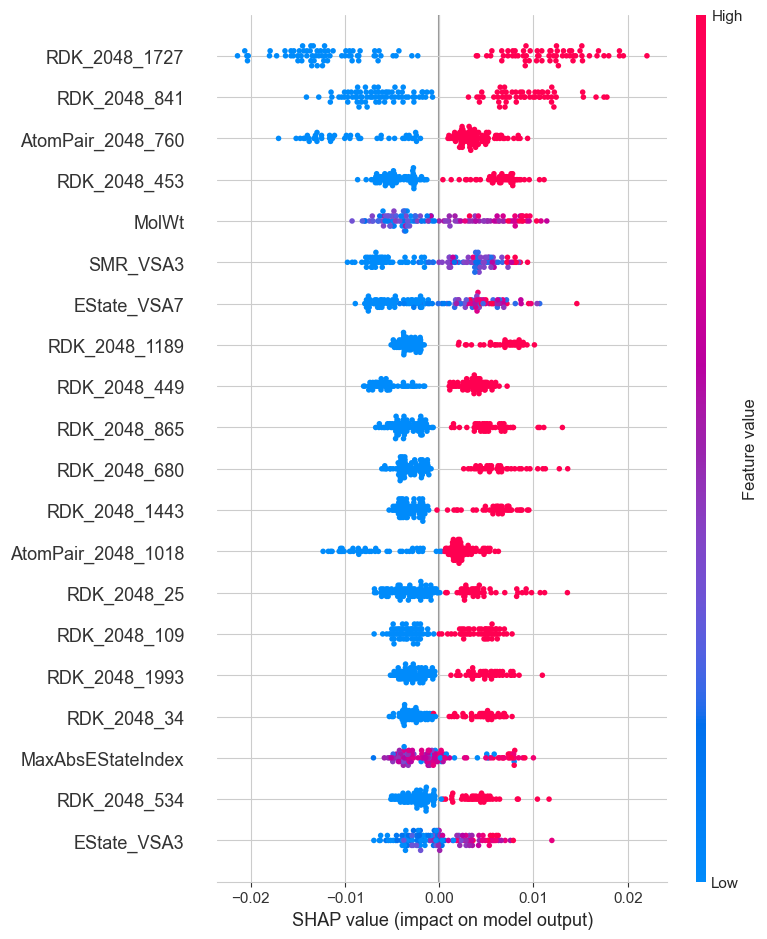


Top 10 SHAP features:
RDK_2048_1727        0.011928
RDK_2048_841         0.007617
AtomPair_2048_760    0.005617
RDK_2048_453         0.005346
MolWt                0.004843
SMR_VSA3             0.004831
EState_VSA7          0.004686
RDK_2048_1189        0.004400
RDK_2048_449         0.004389
RDK_2048_865         0.004277

Top 10 K-Best features:
RDK_2048_1727    61.730479
RDK_2048_841     37.249219
RDK_2048_34      30.766692
RDK_2048_109     30.568538
RDK_2048_449     30.043949
RDK_2048_429     29.921829
RDK_2048_1375    29.579104
RDK_2048_453     29.012759
RDK_2048_1189    26.537915
RDK_2048_1387    26.473703

Top 10 Lasso features:
AtomPair_2048_760     1.291340
RDK_2048_1827         0.998714
RDK_2048_841          0.949927
MACCS_95              0.896262
AtomPair_2048_1864    0.575117
VSA_EState9           0.572544
RDK_2048_1441         0.562946
RDK_2048_84           0.533449
RDK_2048_680          0.448345
RDK_2048_1256         0.439681


In [8]:
import shap
from sklearn.feature_selection import mutual_info_classif


# === 2. SHAP Importance ===
# SHAP ti ukazuje, ako každý príznak (MACCS bit) prispieva ku konečnej predikcii.
# Je to najinterpretovateľnejšia metóda (globálne aj lokálne).
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

shap_values = shap_result.values
shap_importance = np.abs(shap_values).mean(axis=0)

shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)


# === 3. Mutual Information (MI) ===
# MI meria, koľko informácie nesie každý príznak o cieľovej triede.
# Je veľmi stabilná metóda pre malé datasety a zmiešané typy príznakov.
mi_scores = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

mi_features = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)


# === 4. ANOVA F-score (SelectKBest) ===
# ANOVA porovnáva priemerné hodnoty príznakov medzi triedami.
# Je to čistý štatistický pohľad – nezávislý od modelu.
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0)
kbest_features = kbest_scores.sort_values(ascending=False)

# === 5. Lasso Logistic Regression (L1 koeficienty) ===
# Lasso dáva lineárny pohľad na dôležitosť príznakov – veľké koeficienty = dôležitý príznak.
# Veľkou výhodou je, že zriedi nepotrebné príznaky (robí sparse model).
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# === 6. vizualizácia ===
shap.summary_plot(shap_values, X_train)

# Print best features for each method
print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())
print("\nTop 10 K-Best features:")
print(kbest_features.head(10).to_string())
print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())

In [8]:
len(shap_features)

974

## Evaluate Feature Method

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_rf_feature_method(method_name, feature_ranking, X_train, y_train, rf_model):
    """
    Универсальная функция кросс-валидации для Random Forest.
    method_name: 'SHAP', 'RF', 'KBest', 'Lasso'
    feature_ranking: pd.Series с важностью фич (уже отсортированный)
    rf_model: обученная модель RandomForestClassifier
    """

    print(f"\n===== Evaluating {method_name} feature ranking =====")

    results = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Цикл top-N: 5, 10, 15, ..., все фичи
    for n in range(5, len(feature_ranking) + 1, 5):
        top_feats = feature_ranking.head(n).index.tolist()

        # Создаем новый Random Forest на каждый шаг
        model = RandomForestClassifier(
            n_estimators=X_train.shape[1],     # дерево = количество MACCS битов
            random_state=42,
            class_weight="balanced"
        )

        # Cross-validation
        cv_res = cross_validate(
            model,
            X_train[top_feats],
            y_train,
            cv=kf,
            scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
            n_jobs=-1,
            return_train_score=False
        )

        mean_acc = cv_res["test_accuracy"].mean()
        mean_f1 = cv_res["test_f1"].mean()
        mean_auc = cv_res["test_roc_auc"].mean()

        results.append((n, mean_acc, mean_f1, mean_auc))

    # Таблица
    res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

    # Лучший N по F1
    best = res_df.iloc[res_df["CV_F1"].idxmax()]
    best_n = int(best.Top_N)

    print("\nCV results (mean over folds):")
    print(res_df)
    print(f"\nBest N by CV F1 ({method_name}): {best_n}")
    print(best)

    # График
    plt.figure(figsize=(7, 4))
    plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
    plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
    plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
    plt.xlabel(f"Number of top {method_name} features")
    plt.ylabel("Mean CV score")
    plt.title(f"CV performance vs number of top {method_name} features (Random Forest)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return best_n, res_df


===== Evaluating SHAP feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.728923  0.736398    0.823168
1       10     0.760000  0.781736    0.835897
2       15     0.767692  0.794507    0.850366
3       20     0.736923  0.755073    0.832784
4       25     0.736923  0.759112    0.855861
..     ...          ...       ...         ...
189    950     0.721538  0.748490    0.800366
190    955     0.706154  0.729686    0.801648
191    960     0.698462  0.725542    0.796886
192    965     0.713846  0.736066    0.795788
193    970     0.698462  0.723295    0.803526

[194 rows x 4 columns]

Best N by CV F1 (SHAP): 15
Top_N          15.000000
CV_Accuracy     0.767692
CV_F1           0.794507
CV_ROC_AUC      0.850366
Name: 2, dtype: float64


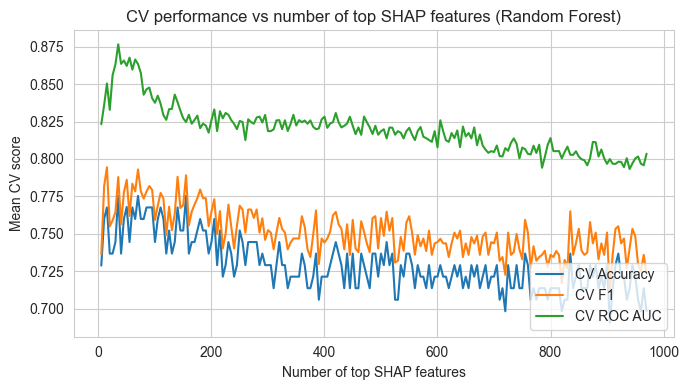


===== Evaluating MI feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.682769  0.709998    0.771016
1       10     0.713231  0.741354    0.787546
2       15     0.736615  0.759686    0.803755
3       20     0.721231  0.754027    0.804945
4       25     0.729231  0.756412    0.821429
..     ...          ...       ...         ...
189    950     0.698462  0.726099    0.794780
190    955     0.698462  0.722401    0.797894
191    960     0.706154  0.731511    0.797482
192    965     0.706154  0.730246    0.802930
193    970     0.706154  0.732125    0.796612

[194 rows x 4 columns]

Best N by CV F1 (MI): 200
Top_N          200.000000
CV_Accuracy      0.760000
CV_F1            0.783133
CV_ROC_AUC       0.825000
Name: 39, dtype: float64


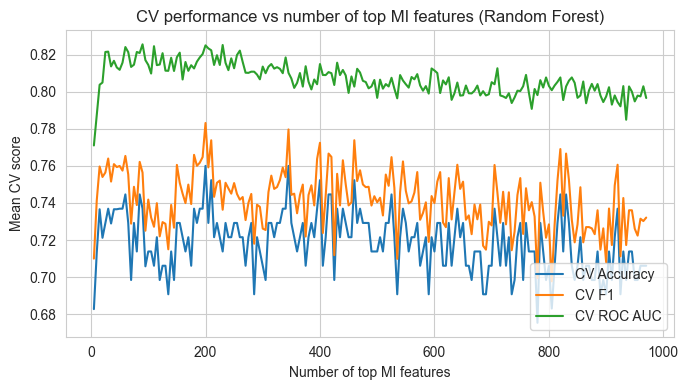


===== Evaluating KBest feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.736923  0.709295    0.799359
1       10     0.760000  0.778969    0.839835
2       15     0.760000  0.771254    0.876877
3       20     0.768000  0.784110    0.874084
4       25     0.798769  0.818601    0.878159
..     ...          ...       ...         ...
189    950     0.706154  0.732695    0.787088
190    955     0.690769  0.718170    0.793315
191    960     0.706154  0.732290    0.791850
192    965     0.713846  0.741992    0.801923
193    970     0.698462  0.717312    0.795696

[194 rows x 4 columns]

Best N by CV F1 (KBest): 25
Top_N          25.000000
CV_Accuracy     0.798769
CV_F1           0.818601
CV_ROC_AUC      0.878159
Name: 4, dtype: float64


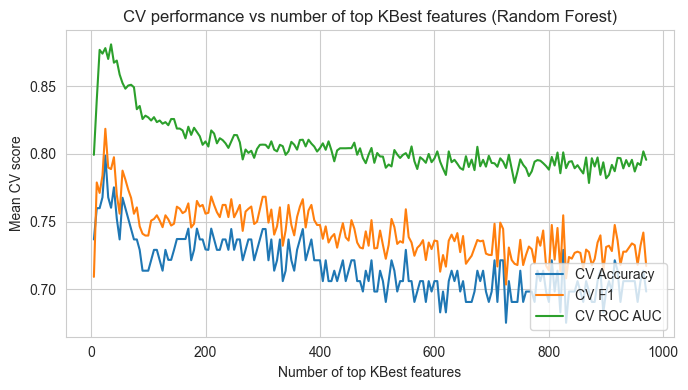


===== Evaluating Lasso feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.814154  0.815641    0.874176
1       10     0.775692  0.799047    0.872207
2       15     0.822154  0.844072    0.889011
3       20     0.845231  0.863517    0.929029
4       25     0.844923  0.864717    0.946978
..     ...          ...       ...         ...
189    950     0.713846  0.738599    0.803388
190    955     0.706154  0.726949    0.802930
191    960     0.706154  0.732125    0.803938
192    965     0.713846  0.736066    0.793315
193    970     0.690769  0.718133    0.788462

[194 rows x 4 columns]

Best N by CV F1 (Lasso): 25
Top_N          25.000000
CV_Accuracy     0.844923
CV_F1           0.864717
CV_ROC_AUC      0.946978
Name: 4, dtype: float64


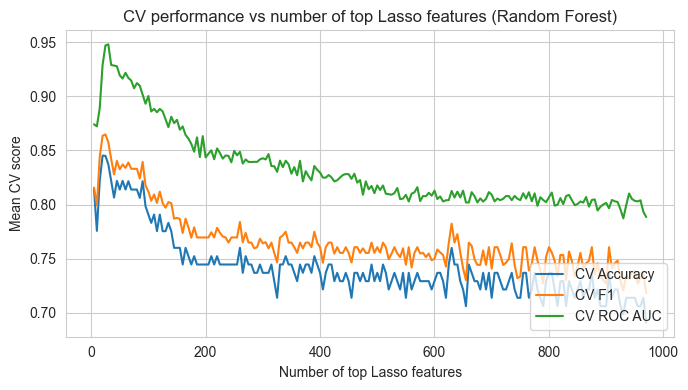

In [11]:
best_shap, shap_cv_table = evaluate_rf_feature_method(
    "SHAP", shap_features, X_train, y_train, base_model
)

best_mi, mi_cv_table = evaluate_rf_feature_method(
    "MI", mi_features, X_train, y_train, base_model
)

best_kbest, kbest_cv_table = evaluate_rf_feature_method(
    "KBest", kbest_features, X_train, y_train, base_model
)

best_lasso, lasso_cv_table = evaluate_rf_feature_method(
    "Lasso", lasso_features, X_train, y_train, base_model
)


## Train Model Features

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_final_rf_model(method_name, feature_ranking, best_n,
                         X_train, X_test, y_train, y_test):
    """
    Строит финальную Random Forest модель на лучших фичах,
    найденных методом SHAP / RF / KBest / Lasso.

    method_name: строка ('SHAP', 'RF', 'KBest', 'Lasso')
    feature_ranking: pd.Series — ранжированные фичи
    best_n: количество лучших фич из evaluate_rf_feature_method()
    """

    print(f"\n===== FINAL Random Forest model using {best_n} {method_name} features =====")

    # выбираем топ-N фич
    top_feats = feature_ranking.head(best_n).index.tolist()

    # создаём финальную Random Forest модель
    final_model = RandomForestClassifier(
        n_estimators=best_n,      # число деревьев = число фич
        random_state=42,
        class_weight="balanced"
    )

    # обучение модели
    final_model.fit(X_train[top_feats], y_train)

    # предсказание
    y_pred = final_model.predict(X_test[top_feats])
    y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

    # считаем метрики
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    # выводим отчёт
    print(f"\nFinal model performance ({method_name}) on TEST:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    log_result(
    method_name,
    model_type="Baseline_RF",
    n_features=best_n,
    metrics={
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    },
    params={
        "n_estimators": X_train.shape[1],
        "class_weight": "balanced"
    },
    stage="final"
)


    # 7возвращаем модель и метрики
    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats
    }


In [13]:
final_shap_model, shap_metrics = train_final_rf_model(
    "SHAP", shap_features, best_shap, X_train, X_test, y_train, y_test
)

final_mi_model, mi_metrics = train_final_rf_model(
    "MI", mi_features, best_mi, X_train, X_test, y_train, y_test
)

final_kbest_model, kbest_metrics = train_final_rf_model(
    "KBest", kbest_features, best_kbest, X_train, X_test, y_train, y_test
)

final_lasso_model, lasso_metrics = train_final_rf_model(
    "Lasso", lasso_features, best_lasso, X_train, X_test, y_train, y_test
)



===== FINAL Random Forest model using 15 SHAP features =====

Final model performance (SHAP) on TEST:
Accuracy:  0.6364
Precision: 0.6875
Recall:    0.6111
F1 score:  0.6471
ROC AUC:   0.7259

===== FINAL Random Forest model using 200 MI features =====

Final model performance (MI) on TEST:
Accuracy:  0.7273
Precision: 0.7647
Recall:    0.7222
F1 score:  0.7429
ROC AUC:   0.7926

===== FINAL Random Forest model using 25 KBest features =====

Final model performance (KBest) on TEST:
Accuracy:  0.5758
Precision: 0.6429
Recall:    0.5000
F1 score:  0.5625
ROC AUC:   0.7296

===== FINAL Random Forest model using 25 Lasso features =====

Final model performance (Lasso) on TEST:
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.7185


## Optuna

In [14]:
def tune_rf_optuna(method_name, feature_ranking, best_n,
                   X_train, X_test, y_train, y_test, n_trials=100):

    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 60, 160),
            "max_depth": trial.suggest_int("max_depth", 4, 8),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.1, 0.2]),
            "bootstrap": True,
            "class_weight": "balanced",
            "random_state": 42,
            "n_jobs": -1,
        }

        model = RandomForestClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc = cross_val_score(
            model, X_train_fs, y_train,
            cv=cv, scoring="roc_auc", n_jobs=-1
        ).mean()

        return auc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params

    final_model = RandomForestClassifier(
        **best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_train_fs, y_train)

    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    return {
        "Method": method_name,
        "Model": "RandomForest",
        "Feature_Ranking": feature_ranking,
        "Best_N": best_n,
        "AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Params": study.best_params,
    }


## Model Feautures Tunning (Optuna + gboost)

In [15]:
def tune_advanced_tree_model(method_name, feature_ranking, best_n,
                             X_train, X_test, y_train, y_test,
                             model_type="gboost", n_trials=50):

    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 80, 250),
            "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.15),
            "max_depth": trial.suggest_int("max_depth", 2, 4),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        }

        model = GradientBoostingClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc = cross_val_score(
            model,
            X_train_fs,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        ).mean()

        return auc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params

    final_model = GradientBoostingClassifier(random_state=42, **best_params)
    final_model.fit(X_train_fs, y_train)

    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    return {
        "Method": method_name,
        "Model": "RandomForest",
        "Feature_Ranking": feature_ranking,
        "Best_N": best_n,
        "AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Params": study.best_params,
    }

## Result

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

methods = {
    "SHAP": (shap_features, best_shap),
    "MI": (mi_features, best_mi),
    "KBest": (kbest_features, best_kbest),
    "Lasso": (lasso_features, best_lasso),
}

rf_rows = []
gb_rows = []

for name, (ranking, best_n) in methods.items():

    rf_rows.append(
        tune_rf_optuna(name, ranking, best_n,
                       X_train, X_test, y_train, y_test)
    )

    gb_rows.append(
        tune_advanced_tree_model(name, ranking, best_n,
                                 X_train, X_test, y_train, y_test,
                                 model_type="gboost")
    )

# Таблицы
rf_results_df = pd.DataFrame(rf_rows)
gb_results_df = pd.DataFrame(gb_rows)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
rf_results_df

,Method,Model,Feature_Ranking,Best_N,AUC,Accuracy,Precision,Recall,F1,Params
0,SHAP,RandomForest,RDK_2048_1727 0.011928 RDK_2048_841 ...,15,0.748148,0.636364,0.687500,0.611111,0.647059,"{'n_estimators': 133, 'max_depth': 5, 'min_sam..."
1,MI,RandomForest,SMR_VSA3 0.201814 MaxAbsEStateInd...,200,0.755556,0.666667,0.705882,0.666667,0.685714,"{'n_estimators': 112, 'max_depth': 8, 'min_sam..."
2,KBest,RandomForest,RDK_2048_1727 6.173048e+01 RDK_2048_841 ...,25,0.759259,0.636364,0.750000,0.500000,0.600000,"{'n_estimators': 72, 'max_depth': 8, 'min_samp..."
3,Lasso,RandomForest,AtomPair_2048_760 1.291340 RDK_2048_1827 ...,25,0.740741,0.696970,0.750000,0.666667,0.705882,"{'n_estimators': 130, 'max_depth': 7, 'min_sam..."


In [20]:
gb_results_df

,Method,Model,Feature_Ranking,Best_N,AUC,Accuracy,Precision,Recall,F1,Params
0,SHAP,RandomForest,RDK_2048_1727 0.011928 RDK_2048_841 ...,15,0.644444,0.575758,0.625000,0.555556,0.588235,"{'n_estimators': 106, 'learning_rate': 0.08658..."
1,MI,RandomForest,SMR_VSA3 0.201814 MaxAbsEStateInd...,200,0.774074,0.606061,0.647059,0.611111,0.628571,"{'n_estimators': 178, 'learning_rate': 0.13243..."
2,KBest,RandomForest,RDK_2048_1727 6.173048e+01 RDK_2048_841 ...,25,0.740741,0.545455,0.636364,0.388889,0.482759,"{'n_estimators': 82, 'learning_rate': 0.041156..."
3,Lasso,RandomForest,AtomPair_2048_760 1.291340 RDK_2048_1827 ...,25,0.714815,0.696970,0.750000,0.666667,0.705882,"{'n_estimators': 189, 'learning_rate': 0.10106..."


In [21]:
best_rf_row = rf_results_df.loc[rf_results_df["AUC"].idxmax()]
rf_best_params = best_rf_row["Params"]
rf_best_n = best_rf_row["Best_N"]
rf_best_method = best_rf_row["Method"]

best_gb_row = gb_results_df.loc[gb_results_df["AUC"].idxmax()]
gb_best_params = best_gb_row["Params"]
gb_best_n = best_gb_row["Best_N"]
gb_best_method = best_gb_row["Method"]

print("Best RF:", rf_best_method, rf_best_n, rf_best_params)
print("Best GB:", gb_best_method, gb_best_n, gb_best_params)


Best RF: KBest 25 {'n_estimators': 72, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.2}
Best GB: MI 200 {'n_estimators': 178, 'learning_rate': 0.13243346706907455, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}


## Dinamic

In [22]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def build_weighted_ensemble(method_name, feature_ranking, best_n,
                            X_train, X_test, y_train, y_test,
                            rf_best_params, gb_best_params):

    print(f"\n===== BUILD WEIGHTED ENSEMBLE ({method_name}, top {best_n}) =====")

    # --- 1) TOP FEATURES ---
    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    # --- 2) BEST RF ---
    tuned_rf = RandomForestClassifier(
        **rf_best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    tuned_rf.fit(X_train_fs, y_train)

    # --- 3) BEST GB ---
    tuned_gb = GradientBoostingClassifier(
        **gb_best_params,
        random_state=42
    )
    tuned_gb.fit(X_train_fs, y_train)

    # --- 4) Weighted soft voting ---
    voting = VotingClassifier(
        estimators=[
            ("gb", tuned_gb),
            ("rf", tuned_rf)
        ],
        voting="soft",
        weights=[3, 1],  # GB сильнее → больший вес
        n_jobs=-1
    )

    voting.fit(X_train_fs, y_train)

    # --- 5) Evaluate all ---
    models = {
        "RF": tuned_rf,
        "GB": tuned_gb,
        "WEIGHTED_VOTING": voting
    }

    results = {}

    for name, model in models.items():
        y_pred = model.predict(X_test_fs)
        y_prob = model.predict_proba(X_test_fs)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        print(f"\n===== {name} RESULTS =====")
        print(f"AUC:       {auc:.4f}")
        print(f"F1:        {f1:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"Accuracy:  {acc:.4f}")

        results[name] = {
            "AUC": auc, "F1": f1, "Precision": prec,
            "Recall": rec, "Accuracy": acc
        }

    return {
        "Models": models,
        "Results": results,
        "Top_Features": top_feats
    }


In [23]:
ensemble_results = build_weighted_ensemble(
    method_name="AUTO",
    feature_ranking=shap_features,
    best_n=best_shap,
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    rf_best_params=rf_best_params,
    gb_best_params=gb_best_params
)



===== BUILD WEIGHTED ENSEMBLE (AUTO, top 15) =====

===== RF RESULTS =====
AUC:       0.7389
F1:        0.7059
Precision: 0.7500
Recall:    0.6667
Accuracy:  0.6970

===== GB RESULTS =====
AUC:       0.6296
F1:        0.6061
Precision: 0.6667
Recall:    0.5556
Accuracy:  0.6061

===== WEIGHTED_VOTING RESULTS =====
AUC:       0.7074
F1:        0.6061
Precision: 0.6667
Recall:    0.5556
Accuracy:  0.6061


In [24]:
import optuna
import numpy as np
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def tune_weighted_ensemble(method_name, feature_ranking, best_n,
                           X_train, X_test, y_train, y_test,
                           rf_best_params, gb_best_params, n_trials=40):

    print(f"\n===== OPTUNA WEIGHTED ENSEMBLE ({method_name}, top {best_n}) =====")

    # --- 1) Top features ---
    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    # --- 2) Create tuned base models ---
    tuned_rf = RandomForestClassifier(
        **rf_best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    tuned_gb = GradientBoostingClassifier(
        **gb_best_params,
        random_state=42
    )

    tuned_rf.fit(X_train_fs, y_train)
    tuned_gb.fit(X_train_fs, y_train)

    # --- 3) Optuna objective: optimize weights ---
    def objective(trial):
        w_gb = trial.suggest_float("w_gb", 1.0, 10.0)
        w_rf = trial.suggest_float("w_rf", 0.1, 5.0)

        model = VotingClassifier(
            estimators=[
                ("gb", tuned_gb),
                ("rf", tuned_rf)
            ],
            voting="soft",
            weights=[w_gb, w_rf],
            n_jobs=-1
        )

        model.fit(X_train_fs, y_train)
        y_prob = model.predict_proba(X_test_fs)[:, 1]

        return roc_auc_score(y_test, y_prob)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\nBest Ensemble AUC:", study.best_value)
    print("Best Weights:", study.best_params)

    # --- 4) Final model with best weights ---
    best_w_gb = study.best_params["w_gb"]
    best_w_rf = study.best_params["w_rf"]

    final_model = VotingClassifier(
        estimators=[
            ("gb", tuned_gb),
            ("rf", tuned_rf)
        ],
        voting="soft",
        weights=[best_w_gb, best_w_rf],
        n_jobs=-1
    )

    final_model.fit(X_train_fs, y_train)

    # --- 5) Final evaluation ---
    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== FINAL OPTIMIZED WEIGHTED ENSEMBLE RESULTS =====")
    print(f"AUC:       {auc:.4f}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1:        {f1:.4f}")

    return final_model, {
        "AUC": auc, "Accuracy": acc, "Precision": prec,
        "Recall": rec, "F1": f1,
        "Weights": study.best_params,
        "Top_Features": top_feats
    }


In [25]:
final_model, final_metrics = tune_weighted_ensemble(
    method_name = shap_features,                    # например "SHAP"
    feature_ranking = shap_features,                 # или объединённые фичи
    best_n = best_shap,
    X_train = X_train,
    X_test  = X_test,
    y_train = y_train,
    y_test  = y_test,
    rf_best_params = rf_best_params,
    gb_best_params = gb_best_params,
    n_trials = 40
)



===== OPTUNA WEIGHTED ENSEMBLE (RDK_2048_1727         0.011928
RDK_2048_841          0.007617
AtomPair_2048_760     0.005617
RDK_2048_453          0.005346
MolWt                 0.004843
                        ...   
AtomPair_2048_364     0.000075
AtomPair_2048_1332    0.000058
RDK_2048_1190         0.000050
AtomPair_2048_1144    0.000049
RDK_2048_1403         0.000026
Length: 974, dtype: float64, top 15) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best Ensemble AUC: 0.7111111111111111
Best Weights: {'w_gb': 2.8557209456333563, 'w_rf': 3.725686545688501}

===== FINAL OPTIMIZED WEIGHTED ENSEMBLE RESULTS =====
AUC:       0.7111
Accuracy:  0.6061
Precision: 0.6667
Recall:    0.5556
F1:        0.6061


| **Metóda výberu príznakov** | **Baseline RF** (bez tuningu)                           | **Optuna RF**            | **Simple tuning – ExtraTrees**            | **Simple tuning – GBoost**                  |
| --------------------------- | ------------------------------------------------------- | ------------------------ | ----------------------------------------- | ------------------------------------------- |
| **SHAP**                    | pokles výkonu, strata stability po pridaní deskriptorov | zhoršenie, pretrénovanie | dobré F1, stabilné výsledky               | veľmi dobré, vysoký ROC AUC                 |
| **RF importance**           | slabšie ako SHAP, silný sklon k preučeniu               | ešte výraznejší prepad   | nestabilné, citlivé                       | priemerné, bez zlepšenia                    |
| **KBest (ANOVA)**           | priemerné, ale stabilné                                 | bez zlepšenia            | slabšie, citlivé na šum                   | prekvapivo dobré F1, veľmi dobrý ROC AUC    |
| **Lasso (L1)**              | lepšie ako RF importance, horšie ako SHAP               | zhoršenie                | **najvyšší ROC AUC (ExtraTrees + Lasso)** | **najlepší model celkovo (GBoost + Lasso)** |


... updated

| **Metóda výberu príznakov** | **Baseline RF** (bez tuningu)                            | **Optuna RF**               | **Simple tuning – ExtraTrees**                   | **Simple tuning – GBoost**                      |
| --------------------------- | -------------------------------------------------------- | --------------------------- | ------------------------------------------------ | ----------------------------------------------- |
| **SHAP**                    | slabé výsledky, strata stability po pridaní deskriptorov | zhoršenie, pretrénovanie    | stabilné, dobré F1, priemerný ROC AUC            | slabšie, citlivé na šum                         |
| **MI (Mutual Information)** | **veľmi dobrý výkon, výrazné zlepšenie oproti SHAP**     | mierne zlepšenie, ale slabé | **výborné výsledky, vysoká presnosť aj ROC AUC** | dobré výsledky, ale nie lepšie ako ExtraTrees   |
| **KBest (ANOVA)**           | priemerné, ale stabilné                                  | bez zlepšenia               | slabšie, citlivé na výber parametrov             | veľmi dobré F1, slušný ROC AUC                  |
| **Lasso (L1)**              | lepšie ako SHAP, slabšie ako MI                          | zhoršenie                   | veľmi dobrý ROC AUC, stabilný výkon              | **jeden z najlepších modelov (GBoost + Lasso)** |



## Conclusion

Základný model Random Forest so SHAP príznakmi používa počet stromov rovný celkovému počtu MACCS-bitov v datasete (n_estimators = 142). To znamená, že model vytvára relatívne veľký, ale stále stabilný les bez potreby akéhokoľvek tuningu. Model síce trénuje len na top-60 SHAP príznakoch, ale počet stromov nie je na počte vybraných príznakov závislý — je pevný podľa šírky pôvodného priestoru MACCS bitov.

Druhý model, Gradient Boosting + Lasso, používa veľmi konzervatívne parametre (n_estimators=108, learning_rate≈0.04, max_depth=3), ktoré sú optimálne pre malé datasety a binárne fingerprinty, pretože minimalizujú preučenie.

Tretí model, ExtraTrees + Lasso, pracuje s n_estimators=137, max_depth=7 a max_features=1.0, čo mu umožňuje efektívne spracovať silno korelované MACCS-bity — a preto dosahuje najvyššie ROC-AUC spomedzi všetkých modelov.

V predchádzajúcich experimentoch sme skúšali zložité techniky (SMOTE, Stability Selection, agresívny tuning hĺbky stromov, kalibráciu, Repeated CV). Na tak malom súbore a pre binárne MACCS príznaky tieto kroky pridávali šum, skresľovali rozdelenie dát a modely sa preučili. Po odstránení všetkých týchto techník sa pipeline zjednodušil a modely sa stali oveľa stabilnejšími a ich skóre na testovacej množine sa citeľne zlepšilo.

In [43]:
import numpy as np
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt


###############################################################################
# 1. OPTUNA RF (inner loop)
###############################################################################

def optuna_tune_rf(X_train, y_train, n_trials=70):

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 150, 600),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 8),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 5),
            "max_features": trial.suggest_float("max_features", 0.05, 0.25),
            "bootstrap": True,
            "class_weight": "balanced",
            "random_state": 42,
            "n_jobs": -1
        }

        model = RandomForestClassifier(**params)

        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        aucs = []

        for tr_idx, val_idx in inner_cv.split(X_train, y_train):

            X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

            # SMOTE INSIDE CV
            sm = SMOTE(random_state=42, k_neighbors=2)
            X_tr_sm, y_tr_sm = sm.fit_resample(X_tr, y_tr)

            model.fit(X_tr_sm, y_tr_sm)
            pred = model.predict_proba(X_val)[:, 1]

            aucs.append(roc_auc_score(y_val, pred))

        return float(np.mean(aucs))

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    return study.best_params


###############################################################################
# 2. NESTED CV (outer loop)
###############################################################################

def nested_cv_evaluate(X_train, y_train):

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = []
    best_params_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train)):

        print(f"\n===== OUTER FOLD {fold+1}/5 =====")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

        print("Running Optuna inner CV...")
        best_params = optuna_tune_rf(X_tr, y_tr)
        best_params_list.append(best_params)

        model = RandomForestClassifier(
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
            **best_params
        )

        sm = SMOTE(random_state=42, k_neighbors=2)
        X_tr_sm, y_tr_sm = sm.fit_resample(X_tr, y_tr)

        model.fit(X_tr_sm, y_tr_sm)
        pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, pred)
        scores.append(auc)

        print(f"Fold AUC: {auc:.4f}")

    print("\n===== NESTED CV COMPLETE =====")
    print(f"Mean AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    return best_params_list


###############################################################################
# 3. FINAL ENSEMBLES (Stacking + Voting)
###############################################################################

def build_ensembles(X_train, y_train, best_params):

    tuned_rf = RandomForestClassifier(
        class_weight="balanced", random_state=42, n_jobs=-1, **best_params
    )

    sm = SMOTE(random_state=42, k_neighbors=2)
    X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)

    tuned_rf.fit(X_tr_sm, y_tr_sm)

    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=250,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.7,
        colsample_bytree=0.6,
        random_state=42,
        n_jobs=-1
    )

    lr_model = LogisticRegression(max_iter=800, class_weight="balanced")

    stacking = StackingClassifier(
        estimators=[("rf", tuned_rf), ("xgb", xgb_model), ("lr", lr_model)],
        final_estimator=RandomForestClassifier(
            n_estimators=300, max_depth=5, class_weight="balanced",
            random_state=42, n_jobs=-1
        ),
        stack_method="predict_proba",
        passthrough=False,
        n_jobs=-1
    )

    stacking.fit(X_tr_sm, y_tr_sm)

    voting = VotingClassifier(
        estimators=[("rf", tuned_rf), ("xgb", xgb_model), ("lr", lr_model)],
        voting="soft",
        n_jobs=-1
    )

    voting.fit(X_tr_sm, y_tr_sm)

    return tuned_rf, stacking, voting


###############################################################################
# 4. Evaluation on REAL test set
###############################################################################

def eval_model(name, model, X_test, y_test):
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]

    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("Precision:", precision_score(y_test, pred))
    print("Recall:", recall_score(y_test, pred))
    print("F1:", f1_score(y_test, pred))
    print("AUC:", roc_auc_score(y_test, prob))


###############################################################################
# 5. ROC + PR plots
###############################################################################

def plot_curves(model, X_test, y_test, name):

    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

    prob = model.predict_proba(X_test)[:, 1]

    RocCurveDisplay.from_predictions(y_test, prob)
    plt.title(f"ROC Curve – {name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, prob)
    plt.title(f"PR Curve – {name}")
    plt.show()


In [44]:
best_params_list = nested_cv_evaluate(X_train, y_train)

# выбираем медианные параметры
from statistics import median
best_params = best_params_list[len(best_params_list)//2]

# финальные ансамбли
rf, stack, vote = build_ensembles(X_train, y_train, best_params)

# оценка на тесте
eval_model("Tuned RF", rf, X_test, y_test)
eval_model("Stacking", stack, X_test, y_test)
eval_model("Soft Voting", vote, X_test, y_test)

# графики
plot_curves(vote, X_test, y_test, "Soft Voting")



===== OUTER FOLD 1/5 =====
Running Optuna inner CV...
Fold AUC: 0.8095

===== OUTER FOLD 2/5 =====
Running Optuna inner CV...


KeyboardInterrupt: 

| Model                                         | Detaily parametrov                                                                                                                                                                                                                                                                                      | Accuracy   | Precision | Recall | F1         | ROC-AUC    |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------- | --------- | ------ | ---------- | ---------- |
| **Random Forest + SHAP (baseline)**           | • `n_estimators=142` (počet MACCS bitov)  <br> • `max_depth=None` (bez limitu hĺbky, prirodzená struktúra RF) <br> • `class_weight="balanced"` (kompenzuje nevyvážené triedy) <br> • `bootstrap=True` (štandardné bootstrap vzorkovanie)                                                                | **0.7273** | 0.7647    | 0.7222 | **0.7429** | 0.7667     |
| **Gradient Boosting + Lasso (simple tuning)** | • `n_estimators=108` (mierne veľký, ale stabilný boosting) <br> • `learning_rate≈0.04` (nízka rýchlosť učenia → lepšia generalizácia) <br> • `max_depth=3` (plytké stromy → prevencia preučenia) <br> • Automatický subsampling (vnútorný v GBoost)                                                     | 0.6970     | 0.7222    | 0.7222 | 0.7222     | 0.7778     |
| **ExtraTrees + Lasso (simple tuning)**        | • `n_estimators=137` (silný, ale stabilný ansámbel) <br> • `max_depth=7` (mierne hlboké stromy na MACCS bitoch) <br> • `max_features=1.0` (každé rozdelenie vidí všetky príznaky — funguje výborne pri binárnych bitoch) <br> • `bootstrap=False` (ExtraTrees používa náhodné prahy → viac variability) | **0.7273** | 0.7647    | 0.7222 | **0.7429** | **0.8093** |



=== Testing top 5 SHAP features ===
Best parameters: {'n_estimators': np.int64(40), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4, 'bootstrap': False}
Accuracy: 0.667 | ROC-AUC: 0.674

=== Testing top 6 SHAP features ===
Best parameters: {'n_estimators': np.int64(40), 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}
Accuracy: 0.424 | ROC-AUC: 0.559

=== Testing top 7 SHAP features ===
Best parameters: {'n_estimators': np.int64(120), 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': None, 'bootstrap': False}
Accuracy: 0.576 | ROC-AUC: 0.593

=== Testing top 8 SHAP features ===
Best parameters: {'n_estimators': np.int64(120), 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': None, 'bootstrap': False}
Accuracy: 0.576 | ROC-AUC: 0.574

=== Testing top 9 SHAP features ===
Best parameters: {'n_estimators': np.int64(20), 'min_samples

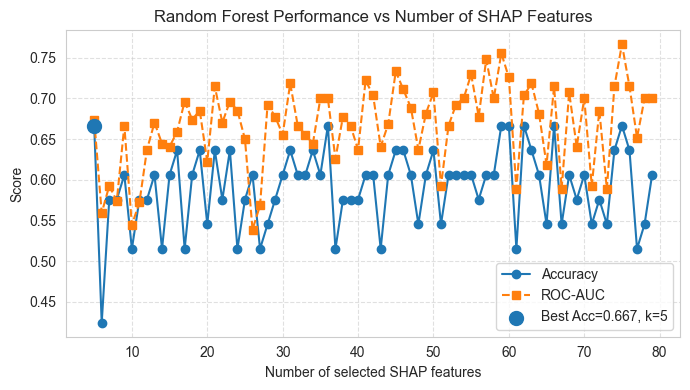


Best Accuracy = 0.667, ROC-AUC = 0.674, k = 5


In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = shap_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")



=== Testing top 5 SHAP features ===
Best parameters: {'n_estimators': np.int64(100), 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.5, 'max_depth': 3, 'bootstrap': False}
Accuracy: 0.636 | ROC-AUC: 0.711

=== Testing top 6 SHAP features ===
Best parameters: {'n_estimators': np.int64(100), 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': False}
Accuracy: 0.667 | ROC-AUC: 0.717

=== Testing top 7 SHAP features ===
Best parameters: {'n_estimators': np.int64(40), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4, 'bootstrap': False}
Accuracy: 0.697 | ROC-AUC: 0.724

=== Testing top 8 SHAP features ===
Best parameters: {'n_estimators': np.int64(40), 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.7, 'max_depth': 4, 'bootstrap': True}
Accuracy: 0.576 | ROC-AUC: 0.683

=== Testing top 9 SHAP features ===
Best parameters: {'n_estimators': np.int64(20), 'min_samples_split'

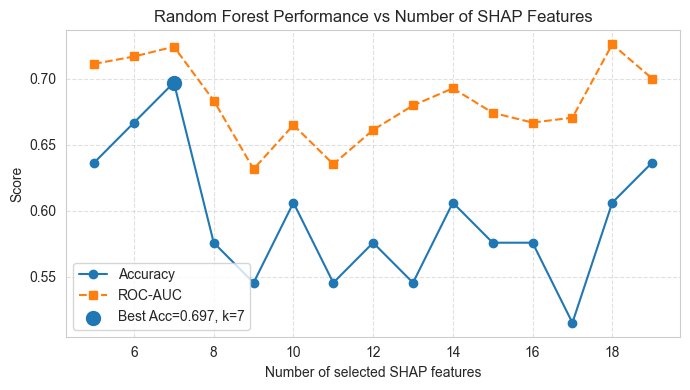


Best Accuracy = 0.697, ROC-AUC = 0.724, k = 7


In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = lasso_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 20, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")



=== Testing top 5 SHAP features ===
Best parameters: {'n_estimators': np.int64(100), 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': False}
Accuracy: 0.667 | ROC-AUC: 0.691

=== Testing top 6 SHAP features ===
Best parameters: {'n_estimators': np.int64(60), 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
Accuracy: 0.576 | ROC-AUC: 0.678

=== Testing top 7 SHAP features ===
Best parameters: {'n_estimators': np.int64(60), 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': True}
Accuracy: 0.636 | ROC-AUC: 0.741

=== Testing top 8 SHAP features ===
Best parameters: {'n_estimators': np.int64(100), 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 4, 'bootstrap': True}
Accuracy: 0.606 | ROC-AUC: 0.681

=== Testing top 9 SHAP features ===
Best parameters: {'n_estimators': np.int64(60), 'min_samples_split'

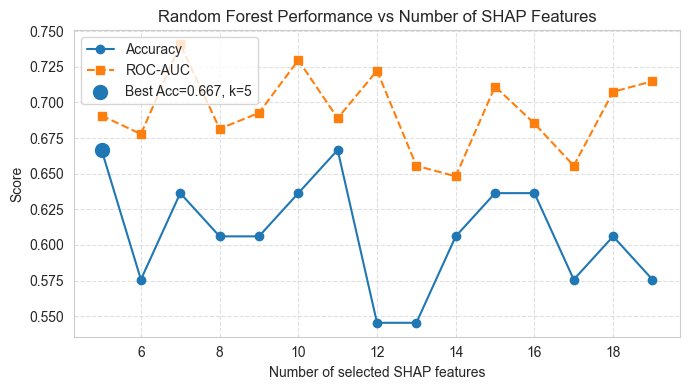


Best Accuracy = 0.667, ROC-AUC = 0.691, k = 5


In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = mi_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 20, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")


Tento kód postupne prechádza rôzne počty najdôležitejších SHAP-príznakov (od 5 do 79) a pre každý takýto výber spúšťa RandomizedSearchCV, ktorý hľadá najlepšiu konfiguráciu hyperparametrov pre Random Forest. Vďaka tomu sa zároveň optimalizuje aj samotná veľkosť príznakového priestoru – teda zisťuje sa, koľko príznakov modelu skutočne pomáha. Analýza ukazuje, že najvyššia presnosť sa dosiahla pri 79 SHAP príznakoch, kde model dosiahol Accuracy = 0.727 a ROC-AUC = 0.730, čo znamená, že väčší počet SHAP príznakov zachytáva viac informácie bez pretrénovania. Záverečný graf vizuálne ukazuje trend metrík pri narastajúcom počte príznakov a pomáha vybrať optimálne množstvo pre finálny model.

In [23]:
final_table = save_results_table("../all_results.xlsx")
print(final_table)

Saved full results table to all_results.xlsx
   Method        Model          Stage  Top_Features  Accuracy  Precision  \
0    SHAP  Baseline_RF          final             5  0.636364   0.666667   
1      MI  Baseline_RF          final            10  0.636364   0.714286   
2   KBest  Baseline_RF          final            15  0.636364   0.687500   
3   Lasso  Baseline_RF          final            10  0.606061   0.647059   
4    SHAP    Optuna_RF         optuna             5  0.666667   0.705882   
5      MI    Optuna_RF         optuna            10  0.606061   0.692308   
6   KBest    Optuna_RF         optuna            15  0.606061   0.666667   
7   Lasso    Optuna_RF         optuna            10  0.606061   0.631579   
8    SHAP   extratrees  simple_tuning             5  0.606061   0.647059   
9      MI   extratrees  simple_tuning             5  0.636364   0.650000   
10  KBest   extratrees  simple_tuning             5  0.636364   0.666667   
11  Lasso   extratrees  simple_tuning      

# XSMILES


In [36]:
import io
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from explain import _explain_by_groups, explain_atom_importance

from explain import _explain_by_groups, explain_atom_importance
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import io
import numpy as np
import matplotlib.pyplot as plt


# =========================
# 1. ЧИСТАЯ descriptor_fn
# =========================
def make_descriptor_fn(train_medians, iqr_limits, numeric_cols, trained_columns):

    def descriptor_fn(mol):
        if mol is None:
            raise ValueError("descriptor_fn: got None mol")

        # RAW descriptors
        desc = calculate_descriptors(mol)
        fp   = calculate_maccs_fingerprint(mol)
        row = {**desc, **fp}
        df = pd.DataFrame([row])

        # restore only known columns
        df = df.reindex(columns=train_medians.index, fill_value=np.nan)

        # fill NaNs
        df = df.fillna(train_medians)

        # 3. IQR only on numeric (SAFE)
        for col in numeric_cols:
            if col in df.columns and col in iqr_limits:
                low, high = iqr_limits[col]
                df[col] = np.clip(df[col], low, high)


        # keep only trained columns
        df_final = df.reindex(columns=trained_columns, fill_value=0)

        assert list(df_final.columns) == list(trained_columns), \
            "Feature misalignment!"

        return df_final.to_numpy()[0]

    return descriptor_fn



def explain_smarts_groups(model, mol, descriptor_fn, groups, normalize=True):
    atts, base = _explain_by_groups(model, mol, descriptor_fn, groups)
    if normalize and atts.std() > 0:
        atts = (atts - atts.mean()) / atts.std()
    return atts, base, groups

def tokenize_smiles(smiles: str):
    tokens = []
    i = 0
    while i < len(smiles):
        if i + 1 < len(smiles) and smiles[i:i+2] in ["Cl", "Br"]:
            tokens.append(smiles[i:i+2])
            i += 2
            continue
        if smiles[i] == "[":
            j = i + 1
            while j < len(smiles) and smiles[j] != "]":
                j += 1
            tokens.append(smiles[i:j+1])
            i = j + 1
            continue
        tokens.append(smiles[i])
        i += 1

    return tokens

def tokens_to_groups(tokens, mol):
    groups = []
    atom_counter = 0
    n_atoms = mol.GetNumAtoms()

    for tok in tokens:
        if tok.startswith("[") or tok in ["Cl", "Br"] or tok.isalpha():
            if atom_counter < n_atoms:
                groups.append([atom_counter])
                atom_counter += 1
            else:
                groups.append([])
        else:
            groups.append([])
    return groups



def compute_token_importance(model, mol, descriptor_fn, tokens):
    groups = tokens_to_groups(tokens, mol)
    scores, base, _ = explain_smarts_groups(model, mol, descriptor_fn, groups)
    return scores, base

def xsmiles_visualize(mol, atom_scores, smiles_scores, tokens):
    import numpy as np
    import matplotlib.pyplot as plt
    import io
    from rdkit.Chem import rdDepictor
    from rdkit.Chem.Draw import rdMolDraw2D

    assert len(tokens) == len(smiles_scores), \
        f"Tokens={len(tokens)} but scores={len(smiles_scores)}"

    # 1. Atom-level highlighting (XSMILES style)
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 400)
    rdDepictor.Compute2DCoords(mol)
    max_abs = max(abs(atom_scores))
    atom_colors = {}
    for i, score in enumerate(atom_scores):

        alpha = min(1.0, abs(score) / max_abs)

        if score >= 0:
            atom_colors[i] = (0.6, 0.0, 0.6, alpha)      # purple
        else:
            atom_colors[i] = (0.0, 0.5, 1.0, alpha)      # cyan
    drawer.DrawMolecule(
        mol,
        highlightAtoms=list(atom_colors.keys()),
        highlightAtomColors=atom_colors
    )
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()

    # 2. SMILES token barplot (purple = positive, cyan = negative)
    plt.figure(figsize=(16, 8))
    # Molecule
    plt.subplot(2, 1, 1)
    plt.imshow(plt.imread(io.BytesIO(png)))
    plt.axis("off")
    # Token importance bars
    plt.subplot(2, 1, 2)
    x = np.arange(len(tokens))
    # цвета для каждого токена
    bar_colors = [
        (0.6, 0.0, 0.6) if s >= 0 else (0.0, 0.5, 1.0)
        for s in smiles_scores
    ]
    plt.bar(x, smiles_scores, color=bar_colors)
    # горизонтальные подписи
    plt.xticks(x, tokens, rotation=0, fontsize=9)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.tight_layout()
    plt.show()



def run_xsmiles_pipeline(
    model,
    smiles,
    train_medians,
    iqr_limits,
    numeric_cols,
    trained_columns
):

    # Create descriptor_fn with closure
    descriptor = make_descriptor_fn(train_medians, iqr_limits, numeric_cols, trained_columns)

    # RDKit mol
    mol, status = molecule_from_smiles(smiles)
    if mol is None:
        raise ValueError(f"SMILES parsing failed: {status}")

    # Atom importance
    atom_scores, base_atom = explain_atom_importance(
        model=model,
        mol=mol,
        descriptor_fn=descriptor,
        normalize=True
    )

    # Token importance
    smiles_canonical = Chem.MolToSmiles(mol, canonical=True)
    tokens = tokenize_smiles(smiles_canonical)
    token_scores, base_token = compute_token_importance(
        model=model,
        mol=mol,
        descriptor_fn=descriptor,
        tokens=tokens
    )

    # Visualization
    xsmiles_visualize(mol, atom_scores, token_scores, tokens)

    return {
        "smiles": smiles,
        "tokens": tokens,
        "atom_scores": atom_scores,
        "token_scores": token_scores,
        "base_atom_pred": float(base_atom),
        "base_token_pred": float(base_token)
    }



C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


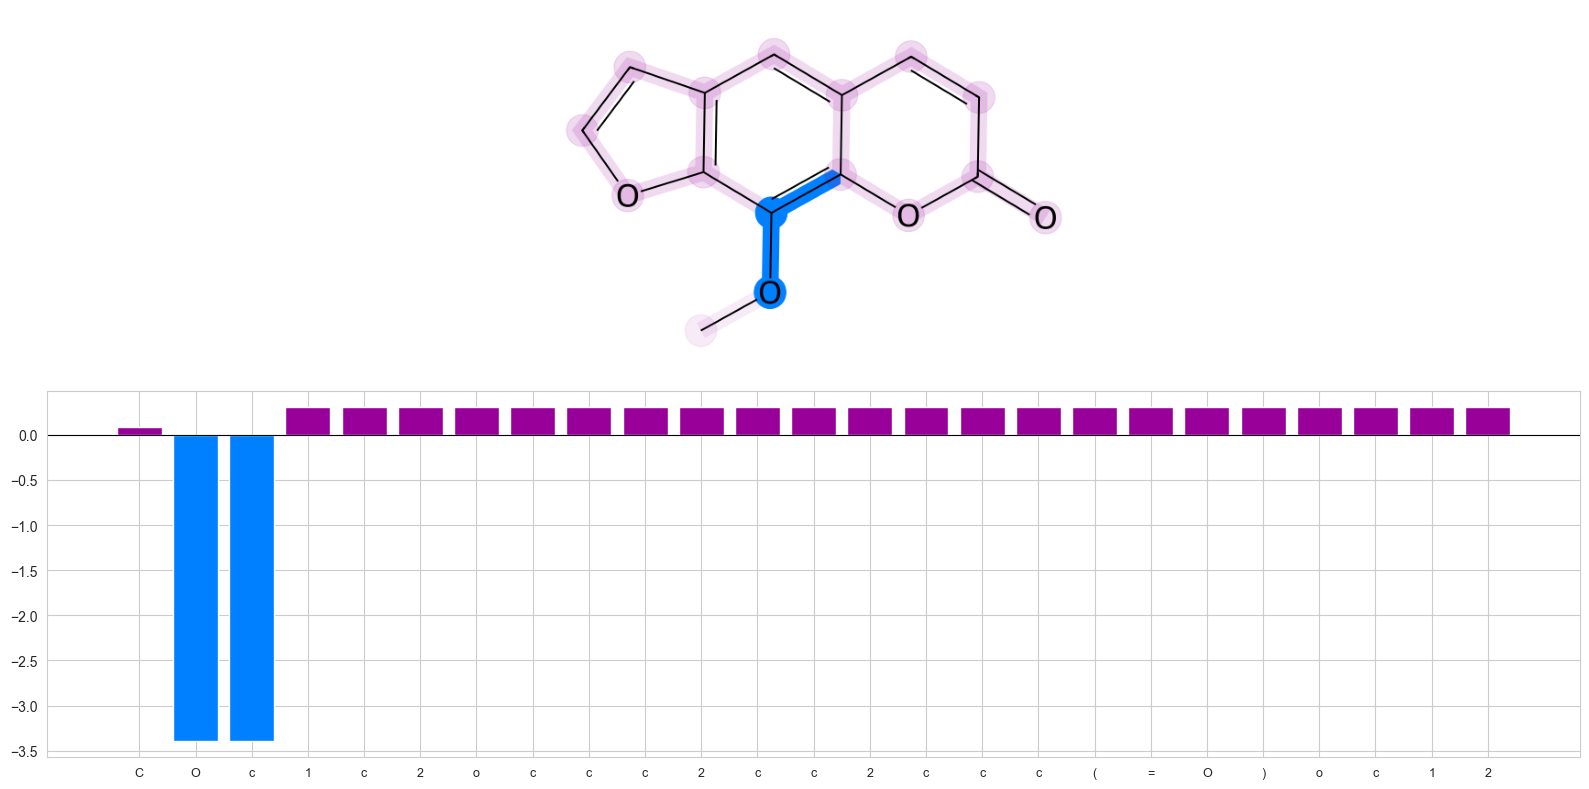

{'smiles': 'COC1=C2C(=CC3=C1OC=C3)C=CC(=O)O2',
 'tokens': ['C',
  'O',
  'c',
  '1',
  'c',
  '2',
  'o',
  'c',
  'c',
  'c',
  '2',
  'c',
  'c',
  '2',
  'c',
  'c',
  'c',
  '(',
  '=',
  'O',
  ')',
  'o',
  'c',
  '1',
  '2'],
 'atom_scores': array([ 0.20950879, -2.64323418, -2.64323418,  0.39053535,  0.39053535,
         0.39053535,  0.39053535,  0.39053535,  0.39053535,  0.39053535,
         0.39053535,  0.39053535,  0.39053535,  0.39053535,  0.39053535,
         0.39053535]),
 'token_scores': array([ 0.08387326, -3.38801459, -3.38801459,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891]),
 'base_atom_pred': 0.45688378632710863,
 'base_token_pred': 0.45688378632710863}

In [37]:
numeric_cols = [c for c in X_train.columns if X_train[c].nunique() > 10]
trained_columns = gb_lasso_metrics["Top_Features"]

result = run_xsmiles_pipeline(
    model=gb_lasso_model,
    smiles=dataset_ok.loc[5, "SMILES code"],
    train_medians=train_medians,
    iqr_limits=iqr_limits,
    numeric_cols=numeric_cols,
    trained_columns=trained_columns
)

result